# Capstone Project - Where to Open up a New Restaurant

Install necessary dependencies and libraries

In [87]:
!pip install geocoder
!pip install folium
!pip install BeautifulSoup4
!pip install geocoder
!pip install wordcloud

     |████████████████████████████████| 368kB 21.5MB/s eta 0:00:01


In [91]:
import pandas as pd
import requests
import numpy as np
import geocoder
from wordcloud import STOPWORDS
from wordcloud import WordCloud
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Done')

Done


# BeautifulSoup4 provides an efficient method of scraping the Wikipedia page for the postal codes for Canada

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

I will need to then convert the HTML data to a dataframe that we can read within the notebook:

In [4]:
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikipedia_page = requests.get(wiki)

df_raw = pd.read_html(wikipedia_page.content, header=0)[0]
df_new = df_raw[df_raw.Borough != 'Not assigned']

df_new.head()

df_new.loc[df_new.Neighborhood == 'Not assigned']

df_new.Neighborhood.replace('Not assigned',df_new.Borough,inplace=True)
df_new.head(8)


df_york = df_new.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x))
df_york = df_york.reset_index()
df_york.rename(columns = {'Postal Code':'Postal Code'}, inplace = True)
df_york.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)
df_york.head()

df_york.shape

(103, 3)

In [5]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M2H')

[43.802850000000035, -79.35620999999998]

# I will pull in the coordinates for the boroughs of Toronto and plot them on a map using a cluster method

In [6]:
url = 'http://cocl.us/Geospatial_data'
df_geo=pd.read_csv(url)
df_geo.head()

df_geo.shape

df_york = df_york.join(df_geo.set_index('Postal Code'), on='Postal Code')
df_york.head

<bound method NDFrame.head of     Postal Code           Borough  \
0           M1B       Scarborough   
1           M1C       Scarborough   
2           M1E       Scarborough   
3           M1G       Scarborough   
4           M1H       Scarborough   
5           M1J       Scarborough   
6           M1K       Scarborough   
7           M1L       Scarborough   
8           M1M       Scarborough   
9           M1N       Scarborough   
10          M1P       Scarborough   
11          M1R       Scarborough   
12          M1S       Scarborough   
13          M1T       Scarborough   
14          M1V       Scarborough   
15          M1W       Scarborough   
16          M1X       Scarborough   
17          M2H        North York   
18          M2J        North York   
19          M2K        North York   
20          M2L        North York   
21          M2M        North York   
22          M2N        North York   
23          M2P        North York   
24          M2R        North York   
25      

In [7]:
address = 'York, Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York are 43.6896191, -79.479188.


In [8]:
map_york = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, borough, neighborhood in zip(df_york['Latitude'], df_york['Longitude'], df_york['Borough'], df_york['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_york)  
    
map_york

# Will utilize the Foursquare API to pull in venues

In [9]:
CLIENT_ID = '3NXM3OVSGUPIA0A3HWIEG0UDSDP1NTIMWXIRLAZYALRQFYLJ' # your Foursquare ID
CLIENT_SECRET = '10BMWLCBA133L3BJMAEKWN2GYP4BUY3LFXP1BUGAKUU41ECP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 3NXM3OVSGUPIA0A3HWIEG0UDSDP1NTIMWXIRLAZYALRQFYLJ
CLIENT_SECRET:10BMWLCBA133L3BJMAEKWN2GYP4BUY3LFXP1BUGAKUU41ECP


In [10]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [11]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.lat',
       'venue.location.lng', 'venue.location.labeledLatLngs',
       'venue.location.distance', 'venue.location.postalCode',
       'venue.location.cc', 'venue.location.city', 'venue.location.state',
       'venue.location.country', 'venue.location.formattedAddress',
       'venue.categories', 'venue.photos.count', 'venue.photos.groups',
       'venue.location.crossStreet'],
      dtype='object')

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Start pulling in the categories of Venues and Locations

In [13]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Petro-Canada,"[{'id': '4bf58dd8d48988d113951735', 'name': 'G...",43.686393,-79.482096
1,Sam and Nancy’s No Frills,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",43.686812,-79.483929
2,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",43.690218,-79.474050
3,Dollar Tree,"[{'id': '52dea92d3cf9994f4e043dbb', 'name': 'D...",43.690296,-79.474667
4,Vin Bon Rogers,"[{'id': '4bf58dd8d48988d119951735', 'name': 'W...",43.685723,-79.477197


In [14]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Petro-Canada,Gas Station,43.686393,-79.482096
1,Sam and Nancy’s No Frills,Grocery Store,43.686812,-79.483929
2,Subway,Sandwich Place,43.690218,-79.474050
3,Dollar Tree,Discount Store,43.690296,-79.474667
4,Vin Bon Rogers,Wine Shop,43.685723,-79.477197


In [15]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Discount Store    1
Gas Station       1
Sandwich Place    1
Wine Shop         1
Grocery Store     1
Name: categories, dtype: int64

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
     
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
York_venues = getNearbyVenues(names=df_york['Neighborhood'],
                                   latitudes=df_york['Latitude'],
                                   longitudes=df_york['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [18]:
print('There are {} Uniques Categories.'.format(len(York_venues['Venue Category'].unique())))
York_venues.groupby('Neighborhood').count().head()

There are 318 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,7,7,7,7,7,7
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",25,25,25,25,25,25
Bayview Village,7,7,7,7,7,7
"Bedford Park, Lawrence Manor East",34,34,34,34,34,34


# One Hot Encoding

In [20]:
York_onehot = pd.get_dummies(York_venues[['Venue Category']], prefix="", prefix_sep="")

York_onehot['Neighborhood'] = York_venues['Neighborhood'] 

fixed_columns = [York_onehot.columns[-1]] + list(York_onehot.columns[:-1])
York_onehot = York_onehot[fixed_columns]
York_grouped = York_onehot.groupby('Neighborhood').mean().reset_index()

York_onehot.head(8)

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium

In [21]:
num_top_venues = 5
for hood in York_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =York_grouped[York_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                       venue  freq
0                  Pool Hall  0.14
1                     Lounge  0.14
2  Latin American Restaurant  0.14
3               Skating Rink  0.14
4            Badminton Court  0.14


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store   0.2
1        Pizza Place   0.2
2                Gym   0.1
3                Pub   0.1
4     Sandwich Place   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
              venue  freq
0       Coffee Shop  0.08
1              Bank  0.08
2              Park  0.08
3             Diner  0.04
4  Sushi Restaurant  0.04


---- Bayview Village ----
                 venue  freq
0                 Bank  0.29
1   Chinese Restaurant  0.14
2                 Café  0.14
3        Grocery Store  0.14
4  Japanese Restaurant  0.14


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.09
1  Italian Restaurant  0.09
2      Sandwich Place  0.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Popular Venues

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = York_grouped['Neighborhood']

for ind in np.arange(York_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(York_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Badminton Court,Pool Hall,Breakfast Spot,Convenience Store,Lounge,Latin American Restaurant,Electronics Store,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Convenience Store,Sandwich Place,Gas Station,Coffee Shop,Pub,Pharmacy,Gym,Drugstore,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Bank,Sushi Restaurant,Gift Shop,Gas Station,Restaurant,Deli / Bodega,Diner,Mobile Phone Shop
3,Bayview Village,Bank,Grocery Store,Japanese Restaurant,Chinese Restaurant,Skating Rink,Café,Women's Store,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Juice Bar,Restaurant,Boutique,Bagel Shop,Café,Butcher,Pub


# K Means Clustering

In [24]:
York_grouped_clustering = York_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(York_grouped_clustering)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 1, 2, 2, 1, 2, 1], dtype=int32)

# Clean the data

In [25]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

York_merged =df_york.iloc[:16,:]

York_merged = York_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

York_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2,Fast Food Restaurant,Spa,Business Service,Coffee Shop,Bus Station,Women's Store,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2,Breakfast Spot,Burger Joint,Bar,Women's Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2,Restaurant,Fast Food Restaurant,Park,Medical Center,Sports Bar,Moving Target,Intersection,Thrift / Vintage Store,Rental Car Location,Bus Line
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Park,Coffee Shop,Business Service,Insurance Office,Women's Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Coffee Shop,Indian Restaurant,Bakery,Fried Chicken Joint,Bank,Athletics & Sports,Thai Restaurant,Gym / Fitness Center,Hakka Restaurant,Caribbean Restaurant


In [104]:
kclusters = 10

In [105]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(York_merged['Latitude'], 
                                   York_merged['Longitude'], 
                                   York_merged['Neighborhood'], 
                                   York_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [107]:
df_1=York_merged.loc[York_merged['Cluster Labels'] == 0,York_merged.columns[[2] + list(range(5, York_merged.shape[1]))]]
df_2=York_merged.loc[York_merged['Cluster Labels'] == 1,York_merged.columns[[2] + list(range(5, York_merged.shape[1]))]]
df_3=York_merged.loc[York_merged['Cluster Labels'] == 2,York_merged.columns[[2] + list(range(5, York_merged.shape[1]))]]

In [108]:
df_1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [109]:
df_2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,1,Park,Coffee Shop,Business Service,Insurance Office,Women's Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [110]:
df_3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",2,Fast Food Restaurant,Spa,Business Service,Coffee Shop,Bus Station,Women's Store,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore
1,"Rouge Hill, Port Union, Highland Creek",2,Breakfast Spot,Burger Joint,Bar,Women's Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Guildwood, Morningside, West Hill",2,Restaurant,Fast Food Restaurant,Park,Medical Center,Sports Bar,Moving Target,Intersection,Thrift / Vintage Store,Rental Car Location,Bus Line
4,Cedarbrae,2,Coffee Shop,Indian Restaurant,Bakery,Fried Chicken Joint,Bank,Athletics & Sports,Thai Restaurant,Gym / Fitness Center,Hakka Restaurant,Caribbean Restaurant
5,Scarborough Village,2,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Coffee Shop,Convenience Store,Women's Store,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",2,Coffee Shop,Convenience Store,Discount Store,Light Rail Station,Bus Station,Intersection,Department Store,Grocery Store,Sandwich Place,Falafel Restaurant
7,"Golden Mile, Clairlea, Oakridge",2,Intersection,Bakery,Diner,Metro Station,Convenience Store,Soccer Field,Coffee Shop,Park,Ice Cream Shop,Bus Station
8,"Cliffside, Cliffcrest, Scarborough Village West",2,Wings Joint,Chinese Restaurant,Hardware Store,Restaurant,Eastern European Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,"Birch Cliff, Cliffside West",2,College Stadium,Park,Farm,Skating Rink,Café,Thai Restaurant,Diner,General Entertainment,Creperie,Dive Bar
10,"Dorset Park, Wexford Heights, Scarborough Town...",2,Bakery,Indian Restaurant,Coffee Shop,Chinese Restaurant,Restaurant,Light Rail Station,Gym,Electronics Store,Pet Store,Vietnamese Restaurant


# Use WordCloud to represent the most popular Venues

In [111]:
stopwords = set(STOPWORDS)

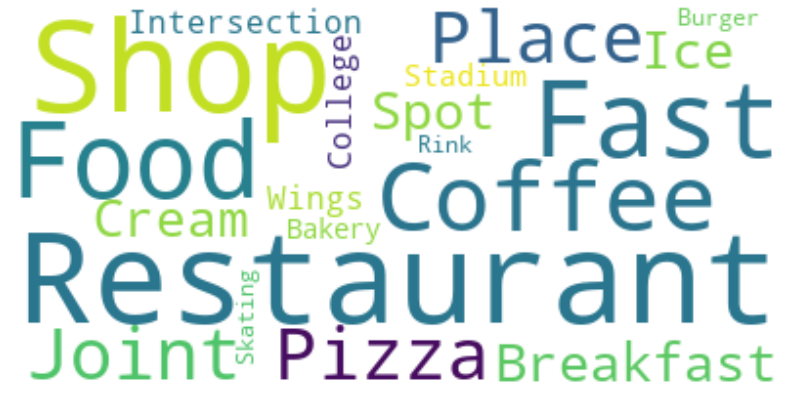

In [112]:
lst_v_dsc = df_3['1st Most Common Venue'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)

stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

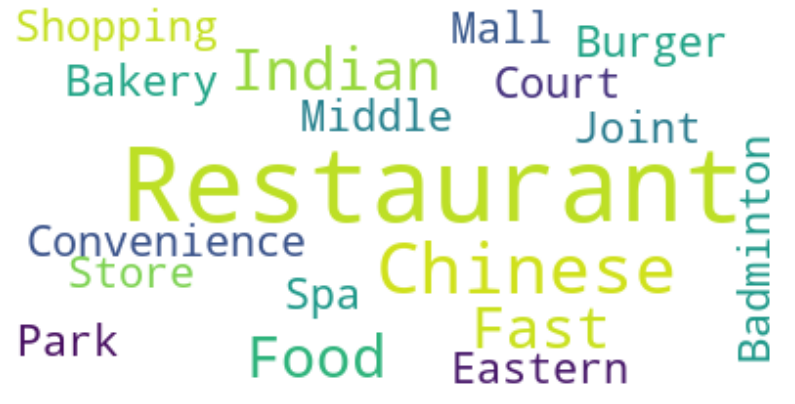

In [113]:
lst_v_dsc = df_3['2nd Most Common Venue'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)


stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

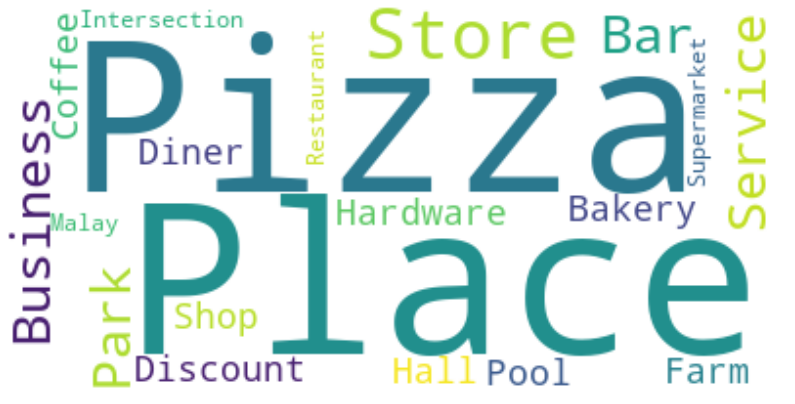

In [114]:
lst_v_dsc = df_3['3rd Most Common Venue'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)


stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

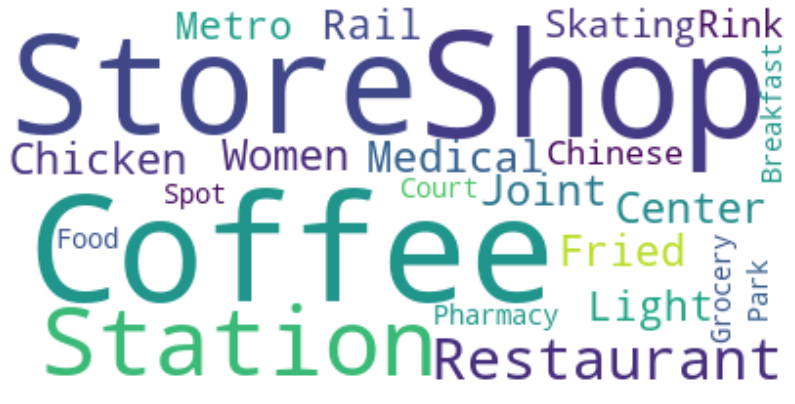

In [115]:
lst_v_dsc = df_3['4th Most Common Venue'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)


stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()